# Figure 4

### Danielle Denisko

In [1]:
import os
from IPython.display import Image
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2,venn3
from scipy.stats.contingency import odds_ratio
from scipy.stats import ks_2samp
import numpy as np
import zepid
from glob import glob
from pybedtools import BedTool

from generate_enrichment_plots import *
from generate_exon_alu_df import *
from io_utils import *
from general_plots import *
from alu_exon_characterization import *
from mfe import *
from statistics_test import *

from io_utils import MyMagic
from IPython import get_ipython

ipy = get_ipython()
ipy.register_magics(MyMagic)

#### Paths

In [2]:
data_dir       = "../"
hexevent_dir   = os.path.join(data_dir, "iralu/")
pickle_dir     = os.path.join(data_dir, "pickles/")
image_dir      = os.path.join(data_dir, "images")
dataset_dir    = os.path.join(data_dir, "datasets/")

bed_dir        = os.path.join(dataset_dir, "bed_dir")
mfe_dir        = os.path.join(bed_dir, "mfe_summary")
bed_random_dir = os.path.join(dataset_dir, "bed_random_dir")
mfe_random_dir = os.path.join(bed_random_dir, "random_sets/", "mfe_summary")

validated_se_df = pd.read_csv(f"{hexevent_dir}/Validated-hominoid-specific-skippable-exons.tsv", sep="\t")

fasta_dir               = os.path.join(bed_dir, "output_notebook")
mountain_dir_1kb        = os.path.join(fasta_dir, "mountain")
mountain_dir_cep290_1kb = os.path.join(fasta_dir, "mountain_cep290", "mountain")

#ref_fasta        = "/reference_databases/ReferenceGenome/GRCh38/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa"

In [3]:
w_open_dct            = {}
w_open_list           = ["1kb", "2kb", "5kb"]
df_names_open         = ["skippable_inverted",    "constitutive_inverted", 
                         "skippable_noninverted", "constitutive_noninverted"]

for w in w_open_list:
    w_open_dct[w]  = {}
    # open original dct of dfs (those that were used for generating BEDs)
    w_original_dct = open_pickle_enrich_dct(f"{w}-dct.pkl", bed_dir) #["constitutive"]
    
    for df_name in df_names_open:
        print(f"w={w}; df_name={df_name}")
        # open MFE results
        dir_df = open_pickle_enrich_dct(f"{w}-{df_name}-dir-df.pickle", mfe_dir)
        dir_df["index"] = dir_df["index"].astype(int)
        dir_df.sort_values(by="index", ascending=True, inplace=True)

        # w_original_dct[df_name] and dir_df should be 1-to-1
        print(f"{len(w_original_dct[df_name])} == {len(dir_df)}")
        #assert len(w_original_dct[df_name]) == len(dir_df)
        if len(w_original_dct[df_name]) != len(dir_df):
            print(f"^the above lengths do not match")

        # merge the two dataframes and return as a dictionary entry
        w_original_df = w_original_dct[df_name].reset_index()
        w_original_df["index"]              = w_original_df["index"].astype("int64")
        w_original_df["upstream_alu_start"] = w_original_df["upstream_alu_start"].astype("int64")

        dir_df["index"]                     = dir_df["index"].astype("int64")
        dir_df["alu1_start"]                = dir_df["alu1_start"].astype("int64")
        
        #w_open_dct[w][df_name] = w_original_dct[df_name].reset_index().merge(dir_df, on="index", how="inner")
        w_open_dct[w][df_name] = (
            w_original_df
            .merge(dir_df, 
                   left_on=["index", "exon_chr", "upstream_alu_start"], 
                   right_on=["index", "chr", "alu1_start"], 
                   how="inner")
        )

w=1kb; df_name=skippable_inverted
13443 == 13443
w=1kb; df_name=constitutive_inverted
9176 == 9176
w=1kb; df_name=skippable_noninverted
15177 == 15177
w=1kb; df_name=constitutive_noninverted
12095 == 12095
w=2kb; df_name=skippable_inverted
43095 == 43090
^the above lengths do not match
w=2kb; df_name=constitutive_inverted
28991 == 28991
w=2kb; df_name=skippable_noninverted
47585 == 47582
^the above lengths do not match
w=2kb; df_name=constitutive_noninverted
34953 == 34863
^the above lengths do not match
w=5kb; df_name=skippable_inverted
167447 == 167076
^the above lengths do not match
w=5kb; df_name=constitutive_inverted
109467 == 109375
^the above lengths do not match
w=5kb; df_name=skippable_noninverted
183671 == 183217
^the above lengths do not match
w=5kb; df_name=constitutive_noninverted
123026 == 122730
^the above lengths do not match


In [4]:
w_open_dct_random            = {}
w_open_list_random           = ["1kb"]
df_names_open_random         = ["skippable_inverted", "constitutive_inverted", 
                                "skippable_noninverted", "constitutive_noninverted"]

for w in w_open_list_random:
    w_open_dct_random[w]  = {}
    # open original dct of dfs (those that were used for generating BEDs)
    w_original_dct = open_pickle_enrich_dct(f"{w}-dct.pkl", bed_random_dir)
    
    for df_name in df_names_open_random:
        print(f"random; w={w}; df_name={df_name}")
        # open MFE results
        dir_df = open_pickle_enrich_dct(f"random-{w}-{df_name}-dir-df.pickle", mfe_random_dir)
        dir_df["index"] = dir_df["index"].astype(int)
        dir_df.sort_values(by="index", ascending=True, inplace=True)

        # w_original_dct[df_name] and dir_df should be 1-to-1
        print(f"{len(w_original_dct[df_name])} == {len(dir_df)}")
        #assert len(w_original_dct[df_name]) == len(dir_df)
        if len(w_original_dct[df_name]) != len(dir_df):
            print(f"^the above lengths do not match")

        w_original_df = w_original_dct[df_name].reset_index()

        # merge the two dataframes and return as a dictionary entry
        #w_open_dct_random[w][df_name] = w_original_dct[df_name].reset_index().merge(dir_df, on="index", how="inner")
        #w_open_dct_random[w][df_name] = pd.concat([w_original_df, dir_df], axis=0, ignore_index=True)
        w_open_dct_random[w][df_name] = dir_df

random; w=1kb; df_name=skippable_inverted
13443 == 13411
^the above lengths do not match
random; w=1kb; df_name=constitutive_inverted
9176 == 9176
random; w=1kb; df_name=skippable_noninverted
15177 == 15177
random; w=1kb; df_name=constitutive_noninverted
12095 == 12095


In [5]:
cohens_d_dct, mfe_dct_1kb = create_mfe_dfs("1kb", {}, w_open_dct, w_open_dct_random)

mfe_dct_1kb["df_skip"]["exon_type"] = "skippable"
mfe_dct_1kb["df_const"]["exon_type"] = "constitutive"
mfe_dct_1kb["df_all"] = pd.concat([mfe_dct_1kb["df_skip"], mfe_dct_1kb["df_const"]], ignore_index=True)
mfe_dct_1kb["df_all"]["exon_length"] = mfe_dct_1kb["df_all"]["exon_end"] - mfe_dct_1kb["df_all"]["exon_start"]

validated_se_mfe = pd.merge(validated_se_df, mfe_dct_1kb["df_all"], 
         left_on=["chr", "exon_start", "exon_end", "upstream_alu_subfamily", "downstream_alu_subfamily", 
                  "upstream_start", "downstream_start"], 
         right_on=["exon_chr", "exon_start", "exon_end", "alu1_subfamily", "alu2_subfamily", "upstream_alu_start", 
                   "downstream_alu_start"],
         how="inner")
cols_to_show = ["exon_gene_x", "alu1_id", "alu2_id", "exon_length"]
display(validated_se_mfe[cols_to_show])

#pd.set_option('display.max_colwidth', None)
#validated_se_mfe[["dir", "filename", "line_number"]]

,exon_gene_x,alu1_id,alu2_id,exon_length
0,NDUFAF7,AluY,AluY,81
1,ATR,AluJb,AluY,192
2,CASP3,AluSz,AluY,121
3,ESRP1,AluSx,AluSx3,110
4,ZMYND11,AluJo,AluY,93
5,SBF2,AluY,AluSx,114
6,DNAH9,AluY,AluYc,228
7,PKNOX1,AluSp,AluY,172
8,CRYBB3,AluSz6,AluSp,143


In [6]:
seq0_header = ">AluY-:AluY+:33519:1kb:skippable_inverted::chr2:37235669-37236798(+)"
seq0 = ("uuugagauggagucucacuuugucaccuaggcuggagugcaguggcgcgaucucggcuuacugcaagcucug"
        "ccuccgagguucacgccauuuuccugccucagccucccaaauagcugggacuacgggcacccuccaccaugc"
        "ccggcuaauuuuuuuguauuguuuuuaguagagaugggguuucaccauguuaggcaggauggucucaaucuc"
        "cugacuucgugauccacccgucucggccucccaaagugcugggauuacaggcaugagccaccacaccuggcU"
        "CCCCUUGCUUAUUUAGAGGAGAGAACUUUCUUACUAAAUAAUUAUUUCACUUUUACAUUAUUUAAGAUUUUG"
        "GAGGGGUAUUUUUAAAAGGCUUAUUUGAAAAUUAAUUUUGUUUCUCUAUUUUCUCUUUUUACUCAGGGUUAU"
        "UAUGUGUACCGUGACAUGCUAGGCGAAAAAGGAGAUUUCAUUACUUCACCUGAAAUAAGUCAAAUCUUUGGG"
        "GAGGUAAUAUACUAUGUAAAGUAUGAAUGAAGCUAAUAUAAACAUUUGAGAGCAGAUCAAAUUGUAUUAUUC"
        "UGUAGUAGUGUUCUACAGCUUUUUUUGUGAUUCAUCAAAAGUUUUAACUUUAUAGUAGUUUAUGUACUGAGG"
        "GAAUAGAGAGGCAGUAGAGGGGAGUAAAAUGGUAGAGAGAAUAUUUGAAAAGUUUAUACUCCACUGUAGGAA"
        "GGGAAAUGGAGAGAUAAGAGGGACAAAGAGAAAGAGAAGGAAAGGAGGGGGUCAUAAAGAGGACAGAAAAAG"
        "GAGAAUCAGAUGAAGGAAGAGAAUGGAAGAAGGggccaggcguaguggcucacaccuguaaucccagcacuu"
        "ugggaggccgaggcaggcggaucacaaggucaggagaucaagaccguccuggcuaacacggugaaacgcagu"
        "cucuacuaaaaaaaaaauacaaaaaauuagccgagcgugguggcggucgccuguagucccagcuacuuggga"
        "ggcugaggcaggagaauggcgugaacccgggaggcggagcuugcagugagccaagauggcgccacugcacuc"
        "cagccucggcgacugagcaaaacuccgucucaaaaaaaaaaaaagagaa")
seq1_header = ">AluJb+:AluY-:41737:1kb:skippable_inverted::chr3:142559656-142560859(-)"
seq1 = ("ggcugggcgcgguggcucacgccuguaaucccagcacuuugggaggccgaggcgggcagaucacgaggucagaagau"
        "cgagaucauccuggcuaacacggugaaacccugucucuacuaaaaauacaaaaaauuagccaagcguggugguuggc"
        "gccuguagucccagcuacucgggaggcugaggcaggagaauggcgugaacccgggaggcggagcuugcagugagccg"
        "agauggcgccacugcacuccagccugggagacagagugagacucugucucacaaaaaaaaaaaaUUUUUUUGAAUAG"
        "UUGAUAUUACAUAGUAUGUUUUAUUCUAAAUAUGUUUCAUGUUUUAACCAAAUUUAUAUUGCAUAUGAAUAUCUCUC"
        "UACUAUAUUCAUAAUUAUAGAAUUAAACAUGUGGACAUGAACCAAAAGAGCAUAUUAUGGAGUGCACUGAAACAGAA"
        "AGCUGAAUCCCUUCAGAUUUCCCUUGAAUACAGUGGCCUAAAGAAUCCUGUUAUUGAGAUGUUAGAAGGAAUUGCUG"
        "UUGUCUUACAACUGACUGCUCUGUGUACUGUUCAUUGUUCUCAUCAAAACAUGAACUGGUAAAACAAACUUCUUGUU"
        "UCUUGGGGUUGGGUUUCCUGUAAUGAACUUGGAUUUACUGUUUACUCAUUAUUCACUUGACUCAUGUAACCUUAGAA"
        "CACAAACUUUUCACUGAAGUAGUuaauaaauuuauuuucuauugagucaaaugcuagguacggugcuaagcacugua"
        "uauaucuuaguuaauauuuacaauaguccuguaagguaaaggcuauuaugccuauuuuaaaaauuagaaacugacac"
        "ucagagaaacugagGCUCUUUUUUGUCUGAAGCCAAAACUGACUUUCCUGGGGACACAUGAUUAGAAAGUACCAGAA"
        "CACAUUUGUGUACAACUCAAAACCCAGUGUUUGGCUGUUGAagacagggucucgcuuugucucccaggcuggugcac"
        "aguggcaugaucauggcucacuacagccuugaucucuauccggggcucaagugagccucccauguagcuggaacuau"
        "aggcaugugccgccacacccuaauuuagaaaaaauuuuuuuuguagagauggguuucccuauauuggcccggcuggu"
        "cucaaacuccugggcucaagugauccucccaccucaggcucccaaagu")
seq2_header = ">AluSz-:AluY+:43626:1kb:skippable_inverted::chr4:184630520-184631568(-)"
seq2 = ("uuuuuuuuuuuuuuuuuuuuuuuuuuagacagagucuugcucugucgcccaggcuggaguacaguggcgcgaucucc"
        "gcucacugcaagcucugccuccuggguucacgccauucuccugccucagccuccugaguagcugggacuacaggcgc"
        "cugccaccaggcccagcuaauuuuuaaauuuuuuuuuaauagagacaggguuucaccauguuagccaggauggucuc"
        "gaucuccugaccucaagucauccgcccgccuuggccucccaaauugcugggauuaaaggcgugagccaccgcgcccg"
        "gccAAUUAACAUCCAUUUUUACAUAGCAUUUCAAUUUUUUAGAACUAAGUUAUGUGUUCACACACAAAUUUUUAUAA"
        "AUAAAUAUUUAUUUUCUAACACCCAGGCCUGCCGUGGUACAGAACUGGACUGUGGCAUUGAGACAGACAGUGGUGUU"
        "GAUGAUGACAUGGCGUGUCAUAAAAUACCAGUGGAGGCCGACUUCUUGUAUGCAUACUCCACAGCACCUGGUGAGAA"
        "CGUUACACAUAAUGAAUGUUACAUGUGGAUUUUAAAUGAAUUAACUGUGACUGAUCAUAGAAUUAUACAAUGAAAAG"
        "UGUGUUUCAGAGACUGUCAAGAUUUUGAUAUCCCUAAAGAUAUCAAAACUUGUCUAUAUUUUAGGGAACCUUCAUCA"
        "AAGAGAAGUCUCAAAAAGUUGUCUUUAGCCAAAAGUUUGGCUAGAAAAUAUGCAUAUAUAgccaggcacagugacuc"
        "acgccuguaauccuagcgcuuugggaggccgaggcagguggaucacuugaggucaggaguucaaaaccagccuggcc"
        "aaccucaucucuacuaaaaauacagaaaaauuagcugggcaugguggcacacgccuguaaucccagcuacuggggag"
        "gcugaggcaggagaaucgcuugaaccugggaagcaaagguugcagugagccaagaucgcaccacugcacuucagccu"
        "gggcgacagagugagacuccgucucaaaggaaaaaaagaaaagaaaa")
seq3_header = ">AluSx+:AluSx3-:52076:1kb:skippable_inverted::chr8:94695780-94698080(+)"
seq3 = ("ggccaggcacagugguucacaccuguaaucccagcaguuugggaggcugaggcagguggaucaccugaggccaggag"
        "uucaagaccagccuggccaacauggugaaacccugucuguacuaaaaauacaaaaaguagccacgcaugguggugca"
        "ugccuguagucccagcuacucaggaggcugaggcaggagaagugcuugaacccaggagguggaaguugcagugagcu"
        "gcgaaugcgacauugcacuccagccugggugacagaacaagacucugucucaaaacaaacaaacaaaaaaCUACUCU"
        "UUGUGUCUUCCAUACUUCAUCUGGGGUGGAGGUAAAGCCACAAAGACCAAGGAUUUACAAACUACCAUGAAAAUACU"
        "UGGUAAUGAGGAUGUCAUUCUGGUCCAUAAACGUGUGUAUAUUUUAGAUGAUGUGUUUUCAUACUGAAUGGACUCUC"
        "AGGUAUCCUUACAUAAGUCCUUUAACAUUUUCAUUUGCUCUUUGUACUACCCUUUACCAUCAAUGCCUUUUACAUUU"
        "UCAAUAGAUGCUAGUUUUUGUUUCUCUUCAAGUACUGAUUAUUGUUUCUUUGGACCUCUCACUACUUGCUGCCCUGC"
        "UGAGAGAAUUAGACUGAUAUUACAAAUACAUCUAACACUAUCUAAAAUUCACUGCAUUGUUUGGAGAUACUGGGUAU"
        "UGGGCUUAUUGUACAAUCCCUUGCAAAUAACUAGUGCUCAAAUAUUUGAUAUGUAAUCAUACUUGCAGUAGCAUGAA"
        "AACAGUACUAGGCAAGAUCUGAAGAAAUUGGCCUCCUAAGUUCUUGUGGUAUGGUGUUUUGUAUGUGUGUGUAAUCC"
        "AUGUUUUCAAUCUAAUGUCCAUCCUAGAAGGGACUUUUAUGGUAUUUAAACAUGUUAAGAAAUAAAGAUUUGGGUUA"
        "GUAGAUAUGUAUAUGGCUUGUACCUGUGUUUGUUUCCUCCUAUCUAAAUGUCCUAUACUUUUGUUGGUAGAUCUAUU"
        "UAGCUGAAAUAUUAUCCAUAGUGACAGUUUGUCCGUCUUUUGAUCUUGUUUGUUUUAACUUGCAUUUUAGUAUGCAA"
        "CCGAGGAUGGACUUAUACACACAAAUGACCAGGCCAGGACUCUACCCAAAGAAUGGGUUUGUAUUUAAGGGCCCCAG"
        "CAGUUAGAACAUCCUCAGAAAAGAAGGUAAGGCUUUAUGAUGUGCAAGUUAAAUUAUAAAGGGCCAAACAGAGAUCA"
        "AGAUUCUGAAGGCAUUUAGAAAUCAACUGAGAGAAUCCUUCUUUUCUUUAGUGUAAUGUAAAAUAUCAGAUAUCCUG"
        "GAAGGAAUGGAGACUAGAAUUAAGUUUGUCAUCUAGGUACAUAGAAUCUAAGCAACAUUAAUGGAUGAGAGUUGUUU"
        "GUUACUGUGGGGCAAGGGAAAACUUUUCCCUUUGGACAUUAAUUUACUAUCUCUCAUGUGGAGUACAAGUUGGGUAU"
        "UCUuuuuuuuaauugagguaaaaauuacauaacauaaaauuaaccauuuuaaacucauuuacaacucagugguuuuu"
        "aguauauucacaaaaucgugcaacuacuaccucaguuuaguucuaaaacauuuuugucacucccuguuuucucuccc"
        "aauagcuccuggcaacuaaucugcuuucugucucuauggauuuggcuauucuggauauuucauguaaauggaaucau"
        "acaugugaccuuuucuguguuugucuuuuuagguucacccuuguagcacguguuaaugcuucauuuguuuuuaugac"
        "ugaauaacauuucauugcauggacauacgacauuuuauuuauccacugauggacauuuuaauuguuugcacuuucug"
        "gcuauugugaauggugcugaugugagcacucauguauaauuauuugaauaucuguuuuuaauuaucuuuggugugua"
        "cccaggaguauaaucacugagucauguagugauucuUUUGGAUUGGGUAUACUUUUUCCUGUUUCuucuuuuauguu"
        "uuauuuuuauuuuuuuugagacagagucuuacacuguugcccgggcuggagugcaauggcauaaucucagcucacug"
        "caaccucugcuccuggguucaggugauucuccugccucagccucccgaguagcugggauuacaggcaccugccacca"
        "ugccuggcuuuuuuuuuguauuuuuuaguagagacaggguuucacuauguuggccaggcuggucuugaacuccugac"
        "ccugugaucugcccaccucagccuuccaaagugcugggauuauaggcgugagccaccgugcccagcc")
seq4_header = ">AluJo+:AluY-:5667:1kb:skippable_inverted::chr10:237360-238655(+)"
seq4 = ("ggccgggcgccguggcucccgccuguaaucccagcacuuugggaggccaaggcaggaggauugcuugagcccaggag"
        "uucaagaccagccugggcaagauggcaagacccugucucuacaaaaauaaaaaaUAAAAAGGUAGAAAAUAUUUUGA"
        "GCUUUAGGAAUUGAUGUCUUACCUGCCUUCCUUUAACCACAUUUAAAUUGAUGUACUAACACCCUCUUAGGCUAUAG"
        "AUCUUAAUAAAAAGGGGAAGGACAAUAAACACCCGAUGUACAGGAGGCUGGUGCACUCAGCUGUGGACGUUCCCACC"
        "AUUCAAGAGGUAAAGUCGGUUUCUUUUAUUUCCACUUCAAGUACAUUUUCUUAACUAACAAGUUAAAGAAUAAUGUA"
        "GCAGUUAAGCAGAUUUUGGUUGCUCUUCUUUCCUUGAAAGUGUACUUUUUUCCACUUCCUAAAACAAAAGACAGGCA"
        "UAACUACCAAAUGAAGCAUUAUUAAUUUGUAAAUUUCAUGUGCUUACUCUAAUGCAAAUUAGGUGUCAUCUUUAAAA"
        "GGCCUGGUUUUAAAGAUGAGCAGCUUGUAGCUUCUUGAUCCUUGUUGAUUUAAGAAAAUGCCUUACAGCCUGGGCAA"
        "UUUAGCAUUUCAGAUGUAAAGAAUGUUUUCCAGGUUUAGCAGUGGUACCUGAGAGUUCCUCUCAGAAAAAAAAGUAA"
        "AGCAUAGAACUGAUCUGCCGUCUUGGGAAACAAUAAAAUGAACAAAAAAAAUUAUGAUUAGAAAAGUUAAUUAUUCU"
        "UAAAGGUCUUAAUUUUACCAACUAUAGCUGAGGAUUGUUAGUUUGUUCACGUCCAGUAACAAAUUGCAACAACAUCC"
        "AGUAGAACACGUAGACAUAUUUGCAGUCAGGGUUACUGAAUUACUGAUUUUGCACCUCAUGUGUCAUGUUGGAAAUU"
        "UAAAAUCUUAACGCUUGGUCAUUAUAGCCUAUAGGGAGACCACAGGAAUAAUUUUAAAUCAUCUUACAAGuuucuuu"
        "ucuuuuuuuuuuugagacggagucucacucugucgcccaggcuggagugcaguggugugaucuuggcucacugcaag"
        "cucugccucccggguucacgccauucuccugccucagccucccgaguagcugggacuacaggcgcccgacaccacgc"
        "ccaccuaauuuuuuguauuuuuaguagagacgggguuucaccguuuuagccaggauggucucgaucuccugaccucg"
        "ugaucugcccgccucggccucccaaagugcugggauuacaggcgugagccaccgcgcccggcc")
seq5_header = ">AluY+:AluSx-:7992:1kb:skippable_inverted::chr11:9997496-9999621(-)"
seq5 = ("ggccaggcacgguggcccacaccuguaauccuagcacuucgggaggccaaggcaggcggaucaccugaggucaggag"
        "uuugagaccacccuggccaacauggagaaacccugucucuacuaaaacuacaaaaaauuagcugggugugguggugc"
        "augccuguaaucccagcuacucaggagggugaggcaggagaaucacuugaaccugggagguggagguugcagugagu"
        "caagauugcaccacuauacuccagccugggcgagaguaagacucugucucaaaaaUAAauacauacauacauacaua"
        "cauacauacauacauacauacauacauacauacaGUCACUGGAGGUAGGACCAACCAAGUGUUGCCAAAUAAAUAAA"
        "AACAGUCGCUGGAGGUAGGACAAACCAAGUGUUGCCAAAUGCAAAUUUCUUAAAAUCGUAAUGAAUAAAUUAGAAUG"
        "AAGUAUAAUAUUGUCAAUAUAACAACUUCACUCAUCUUGGUUGUUUUCUCUUACACUUUUAUGUAAGUUAUUUUUAA"
        "AUAGACUUUUGUAAAAUGCUAAAGAUCAGCUUUUUCUAAGUGGCUAAACAGCACCCUUUUGAUGUAUACUAAUUGUU"
        "AAUUCUUAUAAUAAAUACUAAUUUUUUUAGAAUAUUACUAAACUACUUGAAUAAAGUGUCUCAAAUGCAAUCCUCUG"
        "UGCUUGCUGCAGCAGCAUAUAUAGUAAAAUCAGAAcaaaaugcaauggcucaaacaaaauaaaguguuaucgaacau"
        "ucaugcagcaguccauagagauguuccauuaugccagaccaguuugcucuaugaagucacucaagauccaaguuucc"
        "uuccuucuuguuucuccaacagaauccucccaggcauugucaucauguguaugcugaaggcugguuugcugccaguu"
        "aauaauuucagucuaagggaaaaggaaagacagcauaggagagcuuuacauauccccugucuugaaggacaggaaaa"
        "cacaugucacuucucauguuuuauuggcagaaucuuagccacaugccacacuuaauuucaaaggaaccugggaaaua"
        "cagGGUAGGUGGGAACUUGUUAGCCCAGAAUUCUACUACUAUGGACAAACAAGAGUCUCUUCCACAUCUGAUUCUUC"
        "UCGUUUUGAAUUAGUCAAGGGAAAAAUAAUUUGCUUAACAACAAAUGUAUUUUGGUAAUUAUAGGUUAAUUUUUUUA"
        "UCUCUUUCAGUUAGAUGUAAUCAUAGCAGAUUUGGAUGGAGGCACUAUUAAAAUUCCCGAAUGUAUUCACCUCUCUU"
        "CCCUCCCAGAACCACUUCUACAUCAGACUCAAUCAGCUCUUUCUUUGGUAUGACAUAUUUUUGUAAUAGUAACUUUC"
        "UCUUUAUUUAAAUCUGAAGCUAAGAUAGCUAAAAUUAAAAAUGUUUGUCAAUGCAGUUUGUUACUUUAAUUUAAAGA"
        "GAGCUAUAUAUUUGAAACAUGAACAUAAUCUCAUACAGUAUUUAGAAUUCUUCAUUUACUAGGUAGUUAUCUAAAGC"
        "AUAUAUUUUGGAUCCUAACUGAAUAUUUGUUCUACAUUCCUUCCUUCAUUCAGCAUACAGGACCUAGUACUGUCCUA"
        "GGUAUUGGAAAUUCACCUUUGAAAACAAGGCUCUGCCUUGAAAUCCCUGAUUCCCCUAAGAUCCCCCAUUAGAUGUU"
        "GGCUUCUCUUCUCUAACCUCCCUAUUGGCAUCUCAUUCCUCUUUGGUACCUACAAAACACUGUAAUAUUGUCUUGCC"
        "AAUACUUUCAGGUUAUUACAGAAAGAUGUGUCAUAUUGAUACAUAAAGUGUCCAAAAUUCAuucuuuuuuuuugaga"
        "cggagucuugcucugucgcccaggcuggagugcaguggcacgaucugggcucacugcaagcuccgccucccggguuc"
        "acaccauucuccugccucagccucccgaguagcugggacugcaggcgcccgccaccacgcccggcuaauuuuuugua"
        "uuuuuaguagagacaggguuucacuguguuagucaggauggucucgaucuccugaucucgugaucugcccgcuuugg"
        "ccucccaaagugcugggauuacaggcgugagccaccgcgcccggcc")
seq6_header = ">AluY-:AluYc+:22121:1kb:skippable_inverted::chr17:11929024-11930782(+)"
seq6 = ("uuuuuuuuuuuuuuuuuuuuuuuuauuugagacggagucucacucugucgcccaagcuggagugcaguggcgugauc"
        "uuggcucacugcaagcuccgacucccggguucaugucauucuccucccucagccuccugaguagcugggacuacagg"
        "cgcccaccaccaugcccagcuaauuuuuuguauuuuuaguagagacgggguuucaccguguuagccaggauggucuc"
        "gaucuccugaccucgugauccgccugccucagccucccaaagugcugggauuacagguguuagccaccgugccuggc"
        "cGUGUUACACucuuaaauuguggucuccagaccaguagcaucugcaucaccagggagcuuguuagaaaugcacauuc"
        "ucaggccccauccuggaccugcugaaucugaaacucugggcuggggcacaagaaucuguauuuuaagaagcccuuca"
        "gguuauucccaugcacaggcaaguuuaaaaacAUUAUGCUGGAAAGCCUUAGGAUAGCAAGAGAUAAGAGUUUAACU"
        "GCAGAAUACUGGGAGGUCCUCACUACUGGGCAUCCCAGAACUCUUUUCUAUGAUGUGAUUUAAGACACUUCUGCCAU"
        "UAAAAGUCAUUGAguugcacaacaugugagugcacguaacgccauuaacuguccacuuaaaaaggguuucagauggu"
        "aaauuuucuguuacgucuuaccacaauuuuuaaaaaUUAUGUGAUGCUAAGACCAGUCCCCCCUCUGGCUGCCUUCC"
        "UGACAACUAUUUACUGCUAACAGAGCUAAGCAGAUGCCUGUAUUGAGGGGGGGCUCCUUCCUUCCCACUAGAACAUU"
        "CACCUGGUGGCCAAGUGGCUCAGCACCCUGGAGAAGAAGCUGGAGGAGCACAGUGAGAACAGCCACCCAGAGUUCAG"
        "GGUCUUCAUGAGUGCAGAGCCAGCACCCUCCCCUGAGGGCCACAUCAUCCCCCAGGGCAUCCUGGAGAACUCCAUUA"
        "AGAUCACCAAUGAGCCCCCCACGGGCAUGCAUGCCAACCUGCACAAGGCCCUGGACAACUUCACUCAGGUACGGCCC"
        "CGGGAGGGAGGCAAAAACAGCAGCACACCUCACAGUCAGCUGAUGCAAACUGGUGGGGGGAGAGCAUGCAACUCAGA"
        "AGGGAGUCGGGUGCUGGUUGGGCUACGGAGCAAUGCUGAUGUGGGUAAAAUGUUCCCACCUGAUGCCCACUCAGGGC"
        "AACCCCACUCUCCAUUGCCAGAUAACCCCAGGGGAGUAGAGCUCAGGACAUUUCUUUGGCAAGAGAUGUGGGGAAGC"
        "CUUCUGCAAGUUUACUGUUACCUAAUAUUCCAAGAUGAAGAAGGGCACGUUGUUAUACAUCUCAUUGAUAAGAUACA"
        "CUGGGUCACACACUGAUGGGCUAUCUUCAGGCAGAGAGAUGAUACUGUCAAUCAGAUGAUAUCACUUGACGUCUACA"
        "UGAAUCUUGAGUAUCAAGGGUUCAAAGAAUCCAGGUGUUAGGUAGUGGGGAUAUGGAUUUGAAAUGUAACUGCAUGU"
        "UAGACCCCCUaaaguauggccccuggaccagcagcaucagcaucaccuggaaacuuguuagaaaugcagauuuuUcu"
        "gucgucccagcuaccugggaggcugaggcaagagaauggcgugaaccugggaggcggagcuugcagugagccgagau"
        "ugugccacugcacuccagccugggcgacagagugagacuccaucuccaaaaaaaaaaaaaaaaa")
seq7_header = ">AluSp+:AluY-:15557:1kb:skippable_inverted::chr21:43009165-43011367(+)"
seq7 = ("ggccaggcaugguggcucacgccuguaaucccagcacuuugggaggcugaggcgguuggaucaucugaggucaggag"
        "uuugagaccauccugaccaacguggagaaacccugucucuaaagauacaaaauuagccgagucaugguggugcaugc"
        "cuguaguccuagcuacuugggaggcugaggcaggagaaucgcuugaacccgagaggcggagguuguggugaaccgag"
        "aucacgccauugcacuccagccugggcaacaagagcgaaacuccaucucaaaaaauaaaaaaaauuagcugggcauc"
        "auggcgggugccuguagucccggcuacuuggggaggcugaguaggagaaucgcuuaaaccugggagggcagagguug"
        "cagugacccgagaucgugccgcugcacuccagccugggcgacagagugagacuccaucucaaaaaaaaaaaaaaaaa"
        "aaaggaauaaaguacugauacccguaaaacacugguaagccuuggacacuuuaugcugagggaaacaagccagacac"
        "cacggucacagguuagacgguucccauuuagacagaaugucuaggagaggcaaauauauagagauagcaaguagguu"
        "cuaacaggcuggggucugggaaaaaauggagaaugacugcuauuggauacaggguuucuuugcggggaucauggaaa"
        "uguuccaaaguugacggcggcaaugcugugcaacuguaaaaaccguugaauugcauacuuucaacggguggaccgug"
        "uggcgugugcauuuucacccaacagagguguuaGUGAAGUAGUGCAGGCAUACACGCAAAGACAUUCUCACGGAGAU"
        "GUAGAACGUAAAUGGAUUCUUUUUUUUCUUUUCUCCUCAGGCAUCCACUAUUUCCAUUAUUAGCUUUGUUGUUUGAA"
        "AAAUGUGAACAAUCUACACAGGGCUCUGAAGGCACAACUUCUGCCAGUUUUGAUGUAGACAUCGAAAAUUUUGUAAG"
        "AAAGCAAGAGAAGGAAGGGAAACCUUUCUUUUGUGAAGAUCCAGAAACUGAUAAUUUAGUAAGUAAAAUAAAUUUUA"
        "UUUUUAGUUUUCAAAAUGUGAAAUCUGUUCAUGAAAUUUUAGGCUUCUAAGUAGAACUUUAGACUGCUUGUAGUUCU"
        "GCUAAAGGAGAGACUCAUACAACUCUAAAAGAAUUUUUAUGGUGUGUGUAAUGUGGAUAUCCCCAAGUCUUCCAGCC"
        "UUCUCUAGGUAUCUuuuauuuauuuaguuuuuauuuUUAGAUUUAuuuuauuuuuguagacacaucuuacuguauuc"
        "ccccagauggucucaaacuccuggccucaagcaaucuucccuccucagucucucaaggcccaaccuacccuuuccuu"
        "uaaaaauaaaauaaaauaggccaggcgugguggcucacaccuguaaucccagcacuuugggaggccgaggugggcag"
        "aucacaaggucaggaguucgagaccagccuggccaacaucuggucucgauguuggccaaaaucccaucucuacugaa"
        "aauacaaaauuagccaggcaugguggcacaugccuguagucccagcuacucaggaggcugaggcaggagaaucacuu"
        "gaacgcaggaggcggaaguugcagugagccgagauugugccacugcacuccagccugggugucagagugagacucug"
        "ucucaaaaaauaaaaauaaaauaaaauaaaauaaaauaauuugagccuccaugccaaauggacacggggauucaguu"
        "cucugcacaguguuuguaaagguccguagggcugGGGUGUUCGGGUGGCAUGUCUGUGACCUGUGUCUGUCCUUGGC"
        "UUAUCAUGGACAUGGACACAGACUUGAGCUGUAUUCUCCAAGACAGCUCUGUCuuuuuuuuuuuuuuuuuuugagac"
        "ggagucucgcucuguugcccaggcuggagugcaguggugugaucucagcucacugcaagcuccgccucccagguuca"
        "agccauucuccugccucagccucccgaguagcugggacuacaggcacccgccaccacgcccggcuaauuuuuuuugu"
        "auuuuuaguagagacgggauuucaccguguuagccaggauagucucgaucuccugaucuugugaucugccugccuca"
        "gccucccaaagugcagggauuacaggugugagccaccacgcccggc")
seq8_header = ">AluSz6-:AluSp+:38366:1kb:skippable_inverted::chr22:25204323-25206555(+)"
seq8 = ("uuuauuuauuuauuuuucgagacagacuccugcucugucacccaugcuggagugcaguCUUUCUCUCUCUCUCUUUUU"
        "AAACAuuuuuauuuauguauuuuuauuucauuuugaguugcagucucgcucugucacccaggcuggagugcaguggca"
        "ugaucucugcucacugcaaccucugccuccuggguucaagugauucuccugccucagccuccugaguagcugggacug"
        "aaggcacaugccaccacgcugggcuaauuuuuguauuuuuaguagagguggcguuuugccauguuggcaaagcugguc"
        "uugaacuucuggccucaagugaucugccugccucggccucccaaaguacugggauuacaggccugagccaccacgccc"
        "ggccCACAGUGACACUUUAAACACCACCCUUCUCCCUCCCCUGCUUCACUCACACCCCGCAGCUGCUCCAGCCCUUUC"
        "UCUUUGUCACAUAACUGAGUCCUCCUUAGAGGGCAGUGGAAGAGGGGAAACUGGGAAGAUUAAACCGGCAUCUGGUUA"
        "GGAAAGAGGGAAAGCUCAUAUGUUGAUACUUUUGAUCUCUGUCCACccucuccuggccucaguuucucuaucauuuaa"
        "augaugggauugaacaagaucuggaaauuccuuuucaguuuuauaaucuacggcucuagguucCUAAAUCAACCAGCU"
        "UUGGAGGAAUCUCCCCGUCCCUCCUACAGUGAAUUUGGGGGUGGAGGCAUCUCCUGAGGCCCUUCCCUCCUGCAGCAG"
        "GUUUGGGGGUGGGUGUUAUUUUGUGGUGACCUGUUGAUUCUUUCCGGCAUCUGGAGCCUCCUUGACCUCUGUUCUGGA"
        "UAUGGGAGCAGCCGCUCACCCCACGAUAUUGCCCUCAGGAUAGUCCACAUCACAAGCUGCAUCUGUUUGAGAACCCAG"
        "CUUUCAGUGGCCGCAAGAUGGAGAUAGUGGAUGAUGACGUGCCCAGCCUGUGGGCUCAUGGCUUCCAGGACCGUGUGG"
        "CGAGUGUCCGUGCCAUCAACGGGACGUAAGGGACCCAACCCUCACCCUUGCCCCAUCUUCUGGUCAGCCAUGCCUCUG"
        "GCUCCAAACAGAAUCAGUGCCCAUAGUUUCUUAuuauuuuauuuauuuauuuauuuauuuuugagacggagucuugcu"
        "cugucgcccaggcuggagugcaguggcgcgaucucagcucacugcaagcuccgccucccggguucaugccauucuccu"
        "gccucagccucccgaguagcugggacuacaggcgcccacgaccacgcccggcuaaguuuuuguauuuuuaguagagac"
        "gggguuucaccguguuagccaggauggucucaaucuccugaccucaugaucugcccgccucggccucccaaagugcug"
        "ggauuacaggugugagccacggcgcccggccAUCGGUGCCUAUAGUUUCUUGCAUGAUUCAUGUUCCCUGCACUCCUG"
        "UACUGUUGAGAUUUCUAGGCAGCCUUGACUUAAAACAAGUAAAAUCUGUUCUCUCCACCUGUUCCCAUCUGAGUCCUU"
        "CCUGCUUUUUUAAACAUCCCCACACCCUUGAACUGAUUCUUGAAAUGUUCUUCCCCCUCACAACUCUUguucuucuua"
        "acaaggggcccaggauguaugcaguuauugagaugugacacaaguuguacagaggagagcaggcuuaucaccucccuc"
        "uuucuaggcuuaauaucaccguugaugcagucuuaggaucaccugcuuuuuguaggugguuacaucucacuUGUGGGC"
        "UUGUAAUCUGGGGUUGGGCCUUGAGAGGUGCCACCUAUCCCUGAUAAUAauuuauucaacaauuuuuuacugaacauc"
        "uacuauaugcuggugugcugauacagagaacaacaagaauggcacauccucuggcccucaaaaaauuugcguagucug"
        "gggcucacgccuguaaucccagcacuuugggaggccgaagugggcggaucaccugaggucaggaguucaugaccagcc"
        "ugaccaccacggagaaaccccgucucuacuaaaaauacaaaauuagccgggcaugguggcgcaugccuguaaucccag"
        "cuacucaagaggcugaggcaggagaaucacuugaaccugggagguggagguuguagugagccgagaucacgccacugc"
        "acuccagccugagcaacaagagcgaaacuccaucuaaaaaaagaaaaa")

#### Extract CEP290 FASTA sequence

In [7]:
validated_se_df_cep290 = validated_se_df[validated_se_df["exon_gene"] == "CEP290"]

# AluY: + (same) and AluSz: -
# AluSc8: - and AluY: + (same)
validated_se_df_cep290 = validated_se_df_cep290.copy()
validated_se_df_cep290["upstream_alu_strand"] = ["+", "-"]
validated_se_df_cep290["downstream_alu_strand"] = ["-", "+"]
validated_se_df_cep290["score"] = 1
validated_se_df_cep290["label"] = (">" \
 +validated_se_df_cep290["upstream_alu_subfamily"]
 +validated_se_df_cep290["upstream_alu_strand"]
 +":"+ validated_se_df_cep290["downstream_alu_subfamily"]
 +validated_se_df_cep290["downstream_alu_strand"]
 +":"+ validated_se_df_cep290["distance_between_alus"].astype("str")
 +":1kb:skippable_inverted:"
 +":"+ validated_se_df_cep290["chr"]
 +":"+ validated_se_df_cep290["upstream_start"].astype("str")
 +"-"+ validated_se_df_cep290["downstream_end"].astype("str")
 +"("+ validated_se_df_cep290["exon_strand"] + ")"
 )

# Uncomment to output FASTA
# (BedTool.from_dataframe(
#     validated_se_df_cep290[["chr", "upstream_start", "downstream_end", "label", "score", "exon_strand"]]
# ).getfasta(fi=ref_fasta, s=True, fo=os.path.join(fasta_dir, "CEP290.fa")))

In [8]:
validated_se_df_cep290

,chr,exon_start,exon_end,exon_gene,exon_strand,upstream_alu_subfamily,downstream_alu_subfamily,distance_between_alus,upstream_start,upstream_end,downstream_start,downstream_end,upstream_alu_strand,downstream_alu_strand,score,label
6,chr12,88060829,88060994,CEP290,-,AluY,AluSz,1451,88060319,88060574,88061770,88062078,+,-,1,>AluY+:AluSz-:1451:1kb:skippable_inverted::chr...
7,chr12,88059897,88060020,CEP290,-,AluSc8,AluY,914,88059405,88059706,88060319,88060574,-,+,1,>AluSc8-:AluY+:914:1kb:skippable_inverted::chr...


In [9]:
for i in range(9):
    header_var = globals()[f"seq{i}_header"]
    seq_var = globals()[f"seq{i}"]
    print(header_var)
    print(seq_var.upper())

for i in range(9):
    seq_var = globals()[f"seq{i}"]
    header_var = globals()[f"seq{i}_header"]
    
    rnafold_basename = header_var.replace(":","_").lstrip(">").removesuffix("(-)").removesuffix("(+)")
    print(f"{rnafold_basename}_dp.mountain.txt\n{rnafold_basename}_dp.ps\n{rnafold_basename}_ss.ps")

>AluY-:AluY+:33519:1kb:skippable_inverted::chr2:37235669-37236798(+)
UUUGAGAUGGAGUCUCACUUUGUCACCUAGGCUGGAGUGCAGUGGCGCGAUCUCGGCUUACUGCAAGCUCUGCCUCCGAGGUUCACGCCAUUUUCCUGCCUCAGCCUCCCAAAUAGCUGGGACUACGGGCACCCUCCACCAUGCCCGGCUAAUUUUUUUGUAUUGUUUUUAGUAGAGAUGGGGUUUCACCAUGUUAGGCAGGAUGGUCUCAAUCUCCUGACUUCGUGAUCCACCCGUCUCGGCCUCCCAAAGUGCUGGGAUUACAGGCAUGAGCCACCACACCUGGCUCCCCUUGCUUAUUUAGAGGAGAGAACUUUCUUACUAAAUAAUUAUUUCACUUUUACAUUAUUUAAGAUUUUGGAGGGGUAUUUUUAAAAGGCUUAUUUGAAAAUUAAUUUUGUUUCUCUAUUUUCUCUUUUUACUCAGGGUUAUUAUGUGUACCGUGACAUGCUAGGCGAAAAAGGAGAUUUCAUUACUUCACCUGAAAUAAGUCAAAUCUUUGGGGAGGUAAUAUACUAUGUAAAGUAUGAAUGAAGCUAAUAUAAACAUUUGAGAGCAGAUCAAAUUGUAUUAUUCUGUAGUAGUGUUCUACAGCUUUUUUUGUGAUUCAUCAAAAGUUUUAACUUUAUAGUAGUUUAUGUACUGAGGGAAUAGAGAGGCAGUAGAGGGGAGUAAAAUGGUAGAGAGAAUAUUUGAAAAGUUUAUACUCCACUGUAGGAAGGGAAAUGGAGAGAUAAGAGGGACAAAGAGAAAGAGAAGGAAAGGAGGGGGUCAUAAAGAGGACAGAAAAAGGAGAAUCAGAUGAAGGAAGAGAAUGGAAGAAGGGGCCAGGCGUAGUGGCUCACACCUGUAAUCCCAGCACUUUGGGAGGCCGAGGCAGGCGGAUCACAAGGUCAGGAGAUCAAGACCGUCCUGGCUAACACGGUGAAAC

In [10]:
# Uncomment this to write the candidates to a FASTA file
# with open(os.path.join(fasta_dir, "validated_candidates.fasta"), "a") as file:
#     for i in range(0,9):
#         print(eval(f"seq{i}_header"))
#         print(eval(f"seq{i}"))
#         file.write(eval(f"seq{i}_header") + '\n')
#         file.write(eval(f"seq{i}") + '\n')

# for i in range(0,9):
#     with open(os.path.join(fasta_dir, f"seq{i}.fasta"), "a") as file:
#         print(eval(f"seq{i}_header"))
#         print(eval(f"seq{i}"))
#         file.write(eval(f"seq{i}_header") + '\n')
#         file.write(eval(f"seq{i}") + '\n')

# then in the terminal in fasta_dir, 1) get interactive session, 2) mamba activate viennarna, 3) run script 01

#### Figure 4B (Random set)

In [11]:
random_set_df = w_open_dct_random["1kb"]["skippable_inverted"].sample(n=4, random_state=42)
display(random_set_df[["line_number", "filename"]])

,line_number,filename
41,125,1kb/random-1kb-skippable_inverted/logs/run_rna...
7138,287,1kb/random-1kb-skippable_inverted/logs/run_rna...
7444,4,1kb/random-1kb-skippable_inverted/logs/run_rna...
888,266,1kb/random-1kb-skippable_inverted/logs/run_rna...


In [12]:
random_seq0_header = ">AluJr+:AluJb-:50260:1kb:skippable_inverted::chr13:101249931-101251853"
random_seq0 = ("acguggaaagacaaaaccuuaauuucagaagauacaauuaucuacauagaaauuccaaucaagucuauggaugauc"
               "acaaacaaccaauuguaguaaaguugcuggcuaugaauuaggucaauauaaaaaauuaauauuauuccuacaucaa"
               "uaaaaauguaauugaaauuauuucauucacaaaagaaacuguaggauauguaggcaugaauguaacaaaaaaugug"
               "gaagaccuuuggagaaaauuauaaagcauuguuggaaaacacuaaggaagguuagaauaacugaauagagauGUUC"
               "UUAACAUCAAUUAAAAUCUCAUUACUAAAAUGAAUUAAAUUUUCAUAAUGUAGAGCAAGAAUAGCaagaccaagaa"
               "cagauaaaacaaaucugaagaagaauaucaacaucaguagcuugcccuaauagaucucaagguuuauuauaaagga"
               "uagcacuuaugacaacauguuaucaacuaaagcuuugauguauagacacagacugagguguccagaaacacaauug"
               "ugcacauguguaaaccugauauaugacagaaauugcacuacaggagugaggaaagaaugaauuuucaaugaaucuu"
               "cgaaggacaauuguuuauauauggggaaaaaaucaaguccuuaucucauuccaaauguauuggagucuaaaauuga"
               "aaaagcacaacuugaaaacucuagccuuuacuauaagagaaugucuuuaaugacucugguauagauaagacacaaa"
               "aagcacugaaucaaaaauuaaagaugacuauaucuuacaguguuaaaauuaauaacuucuauugaagaaaagacag"
               "caaauaaaaguuaaaagacaagcugaaggcugggagaugucugcacugcauaCUACUAGAUAACUGAAAAAUCAAU"
               "UAGGGUACAGAUuaaacaggcaaaauuauagaagaggaaauucagggcugacagaauacgaaaaaaaggucaaauc"
               "ucuaugguaaccaagaaaauguauauuaagacuauaaugauuauaugagauuguaagaaacuuaaaaauccugaac"
               "aaaaaaaaguaguaugaaguagagcugcucauauauccugguaggaauguaaauugacacaagcacuuugaaguuc"
               "aauuuaacaauauuuagcaaaguugaaagugagcauaucugacaaauucacaauuuuaagucuagguauauauuua"
               "gaaagagcucucccaaauguggcacagaaauucuaaugacaauguuuacugaaguauuguuuucaacagcaaaaag"
               "uuggaagcaauugaaauacccauUGCCCUUACAUGCAGAACAAAUAAAUUCAUGCUUCAAUCGACAUGAAUCAAUU"
               "UCCCAAAUAUAAUGAGGAUUGAAAAAGUGGCACCUUAAUACUUCAUACUauuauaaagcaugcauugauaugauga"
               "auauaguucucuguggauuagggagaaggaggagaucaagaagugguacacagggaucuucuacucuacuaaugau"
               "guuuuauuucugauugaaaaaccugacccaaacaugaaaaacuauuaauuuuuuaaaaaucugggugacggacaca"
               "caaauauugguuauaauauuuucucuauguguugaauuuaugaaauacuuucuaauuAAGAAGGAAAUAAAAGAAA"
               "GUCACAGAUUUUCAAAGGAUAGAAAUUUCAAAAAGAAGGAAAAAUAACCAUAGAAAAAGAAUCCUGCAAAAUAAUC"
               "AUAUUAAUACACAAAGGCUAAUGGUUGCUUCUGACAUCAUAGGUAUCUGACAUAAAUAAGUCUAAUCCUGCCCAAA"
               "UCUUAUUUGUGUAAAAUUAAUUUAGUCUCAGCACGUUUUGCUUCAUCAAUAAUCUGUUUUAGAAACAACAUUCUCU"
               "CAAGCUGUAACUUCUCUCAGCG")
random_seq1_header = ">AluJr-:AluSp+:14546:1kb:skippable_inverted::chrX:18455405-18457720"
random_seq1 = ("aaaugcaacugacuuuuggauacaaagcauccagcuuaauauaagggagcagaagugugaaguugaacuagauagu"
               "uaaccauuagccaaaaacauuuguacugauggcaacagccagaucucuguuuuccagagguaaugaggaguuugau"
               "gaggaguuugguaacuguuagguugaggacuguuaagaggccugcuGGAGGCCAGUAUGGCACUUCAGUGCACAGU"
               "GCAAACCCGCUUCUGUAAUGCAUUUUAUACUUUUUAAAAAUUCCAUUUCCCAUGAAUAACAUGCUUUUUUAUGUAA"
               "CAGAAGAUAAUCGUAACAAUUAUCAUGUAACAGAAGAUAACUGUUAUUUGGAAUGCUUGGAGAAAAUCACUGUUUA"
               "AGAUUUCUGUAAAGCCUUUUCCUGUCCAAGAUUUCUGUAAAGCCUGUUucugucauugccugaaacaucauuaugc"
               "agcacgugacuACCUUUAUUUUAGCACUUCUCAUUUGGAGUUAACCCUUUCACCUUUACUAUGAGGUCUUCCUCUG"
               "AAAAACUUUUGUAUACAACAUCUGAUCCACAGUUGAUACCCAACAAACUGAAUGAAACAGAAGUUCUGGCCACUUA"
               "AGUAGAUGUCACAACCCAAUCUuuuucuuucuuucuuucuuuuuuuuuuuuugagacggaguuuugcucuugucac"
               "ccaggcuggagugugguggugcucacugcaaucuccgccucccagguucaagugauucuccugccacagccuccug"
               "aguagcugggauuacaggugcccaccaccacgcccagcuaauuuuuguauuuuuaguagagacgggguuucaccau"
               "guuagccaggcuggucgaacuccugacuucaggugguccacccaccuuggccacccaaagagcugggauuucaggc"
               "gugagccaccgcgcccgcccGUCACAACCCAACCUUCCGUCACAACCCAAUCUUGAUGUGGUGUAGUUUUCAUUGA"
               "UGUGCUACUGAAAAAUAAGCUGUUAUUAUUUAUAAACUCAGUUCAGAGAAUAUUUUAGGAUAAUUAUACUCAGUUG"
               "AGUAUAUUAUAUUCCAUAUGUCAAAGAUGCUGUGCUAUGUCUACAGAGUUCUGAGCUUAAUAAUACAUAGUUCUUG"
               "UCUGUGGACAUGUAUAUUGUUGGUACAGUGGGAAUAUAUGAGGAGGAGAGAUUAAUUCAAGCCUGAAGGAAUUUGA"
               "GAGGAUUUGAGAGUAGAUAGGACCUGAACUGGACUUGGAAUGGUAACAAUAAUUAGGAUUUUUUGGCAGAUAUUUU"
               "ACUGCUUUAUGGCAUUGGAUAGUCUGGAUCUCCUUCAAAUUCUUUUCCCUUCUUUUCUGUCAAAUACACCUAGUCU"
               "UCCUACUUCCAUCUCUAGCCUUCUUCCUCUGCAAUAAUCUUUAUUUUCCUUAACAAUCUAUUGCUUUUGGCCAUUU"
               "UCCUCUUCUUUCUUGCCCUUGGUGUAAUGCGUUAUUGUUUUAACCCUAACCCUGUGCUUCUGGAAAUAUGCUUUUC"
               "UAucuucuacauagccacaacacuucaucaguauccuucuuagagcauuuaucguuucuuugcacuauaguuacau"
               "acagacuccauccucugcuggaccuuaacuucuugagggcaaguugcaccuuuauaguucuuaaaguaucuaguau"
               "auaguUUUCUAAGUAGUAGGCACCACAUACUAUUCUCUUACAUUUAGCUUCUUUCCUCAAACUCAACUCCUCUUCU"
               "AGACUUGCCUUUUUCUGUGCAUAGUACUAGAGUUCUUUCAAUUCCCCAUUCUGGUCAGUGAGUUCUGCUUCUGUCU"
               "UUGAAAUGUUAUUUGUAGCCCCACCAUUUUUUCCACUGUCGUCAUUGCAUGCCAAUUAAAAGauaaauauuuagug"
               "cauauuguucuaagcacuguguaggugcuaggaauacaaauauaacagauccaauuccuuguucuuagaauccuag"
               "ucggggAUUAUUUUGGUACUUUGUUGAGCAaauguuuauugaacacuuucucugugcggagcucuauuguaggcau"
               "agauguauuauaucauuuUCCACAGGCUGCUCAUCUUCAAGGGGAAAACAUGGCUAcuggauuuccucuguucuaa"
               "gguacacuuuucuucccauuuucuucuagcaucucugaaauccagaugcgucuAAACCCUGGUAUGUUUAAUGuuu"
               "uuuuguuuguuuguuuguuuuuuuuugacugagucucgcucuguugcccaggcuggagugcaguggugugaucucg"
               "gcucacugcaaccucugccuccuggguucaagcaa")
random_seq2_header = ">AluSx-:AluSz+:23025:1kb:skippable_inverted::chr1:54047549-54049443"
random_seq2 = ("GGUUUUAGUUCCUUAUUUUAAAAGUGAUACGAAGAAAAAAGCCUAGUAGGUAAAACCACCACCCUUUUUCCAUUUU"
               "CUUUGGUUACAAUCUGUGGGGGGGAAAAAUUAAAAAUAAAACUAAUAGUGACAggccaggugcaguggcucacacc"
               "uguaaucccagggcuuugggaagcugaggugggaggacugcuugaggccaacaguuugaggccagccuggacuaua"
               "uagcgagaccccaucuguaccaaaacaaacacacacacaaaaauaacuggguaugguagugcacacuuguuguccu"
               "aguacucaguaggcugaggugugaggauuguuugagcccaggaguuugaggguacagugagcuauaaucacaccac"
               "uguacuccagcuugggguacaaagugagacccuguugcuuaaaaaacaacaacaacaaaaaaCACAACGGUGAUAU"
               "AACUAGAACUUUAACAGCGAUAGGAGUAAGCAAGUACCCUAGGACCAAUGGCAUACUUCUGCCACAUCCCUGUUUA"
               "UAUGAAUCACCAGGCUUAUCAGGAAAAGUAUCAGACUAGCUUCACAUGGCAAAUGGUGACACAAGGGCCUGAUAAA"
               "GUAAGGUAUACAUCUAUAAAAAUGUUUAUAUGAAGGGAUUUUUUAAAACUGGGCUUACAUUAAAUGAAAACACAGg"
               "agcaacagugugguguaugggaaaggacacugcaaucagccagaccuagaucaaaccuuuugggugagugcauaag"
               "uuauuuuaccugucuaagaaucucagcuuucucaucaaaaaaggagagaacagccauuaucuccaaauuccucaau"
               "aauuuggaagcuauuuccaguauagugccugggauguagaaggugcuuaauaaaugguaAUAGUGUUAAUAGAUUU"
               "UUAAAAUAGAAAACAAUUACAGGCAUCAAUGUAUACGUGUGAAAGCUUAAGACAGGAUGGACAUCUGGUUCUUCAU"
               "UACUGUAAAAUAUUAACUGCUUAAUAAGACUAAUGUCUUCAGCUGUUUUUCUUUGAUAAAAUAAAAGUAUUUAAAA"
               "AAAGCUAUUGCAUAUGGGGGAGCCCCCUCGACUUACUAUGUGAUCCACUGUGUACAAACUGGCAGACACCUAAUAA"
               "GGAAACAGCAUGUGCAUAUACCAGUUAGCAACCAAUGAAAUACAAGCUAUGUAUUUCUUUCCAGCAAAAGGAUUAG"
               "UAAAAUUUACGCAGCAGCAACAAUCCAUCAAGAAGAGAUGCCUGCAGUCUAAUAUUAAAUAUACUUUAUCAUACAA"
               "CUUUGAAGGUAGCACACUUUUGGACCUCAGUUCCAACUGCAUUUACUGUUAAGAUGAAAUUGAAAGAAUUUUAACA"
               "AUUGAGAUAGAUUUCAUAUCUGAGUAGCUGUUGCAGGCUUUGUAAAACAGUUAAAGAAUUAUUUUAUGUCUCUGGA"
               "GCACCACAUAUUUCCUUAUAUUGCACAAAGGAAGCAUAAGCUCAUUAGUAUGAGCUAUACCACAUGCCAUUUCAUU"
               "CUCAGAUAUGCUUUCCUUUAAUAAGUCAUCCAGUACCAAUUUCGGAAAACCAUAuggcauggugaaaagagccgag"
               "guuucaggaaucggcccugguuugaagcucagacuugccacuuauucugcacaaccuuugacaaguuacuuaaucu"
               "aauuccucaguuguaaaauaaggacaauacucuuacaucAAUCCUAACUACUAUUCAUUUAUUUUCUACUGCCUGU"
               "AUAAUUGCAGAGUGUCAAUCUUCACUAUUAGGAGAAUUAUAUAUUUAUAUCUACAAUAGCAUUACUACUAUGUAGU"
               "ACUAUCuaauagacagacauauuuaaugagcauccacaaugugccaggcacuguauuaagacuuaacaAA")
random_seq3_header = ">AluJb+:AluJb-:45525:1kb:skippable_inverted::chr7:108432243-108433874"
random_seq3 = ("AUGUCAUUGAUCCUUUAAUAUGGAUUACUUAAAAUGCAAUUAAUGGCUAUUUCCACUGACUCUUCAGAGACAAGAU"
               "UAGAAUCCUGUAAAUUAUGCCAAAUCAUAUGUUCUUCUUGUUCGAAGAAUUGGUGUAACAAGACUAUGGAUUUCUA"
               "CGAAACAGUAAGCAGGAGCAUAAGCAUAAGCAUCUUUGCUCCAACCCUAAGUGGCUAGCUGGAACAAUGGAGGAUU"
               "CUCAAAGUUAUAAAAAACCCAGUAAAUGGACAUGUUGAAAAUUUGUUGACAUACUUUGAGUAUUUAGUGUGCACAC"
               "UGAAGAGGAAAUCGAAGUGUUCUCUCACACUGCAAUACAGACAUGGGGAAAAAAAGAAGCAGAAAAACUGGAGUCU"
               "Ugggcgagguggcucucgccuguaaucccagcacuucgggaggccgaggagggcagaucacuugagaucaagaguu"
               "cgagaccaaccuggucaauaugugaaaccccaucucuauuaaaaauauaaaaaucagccaaguguggugguacgca"
               "ccuauaguccuagcuacuaggaagcaugagacaggaggauggcuggaaccugggaggcagagguugccguaagcac"
               "cacugcacuccagccugggugacagagugagacucugaaaaaagaaagagagagagagagaaagagaaagagaaag"
               "aggagaaagagaaagagaaggagaaggagaaggaggagaaagagaaaaagagaaaagaaaAACUGGACUCUGUCCA"
               "UUUUGUGUUUUGGCCCAAAGAUAAAAUAAUUUCAACCAAACGUUUCCUGAAGUACCCAUAAGCAGGCCUAAUCAUA"
               "CUUGGAGCAAGAGUGCAAAUGGAGGCUCUCUUUGUUCCCACCCAUCCCAGUCCUGCUUCUGUGCUUCUGUGUGUAG"
               "AAUCCCAGCUUGAAGGUCCAAGCUUUCCAAGCAUUGUCUUCCAUAUCCCCUCAACUCCCAAUACCUUGAGAUUGCA"
               "CGCCCCCACCCCGCAACCCAGCUACCUCCUAACUACCCCUCCAGCCUGUGGGUGUACACACUUGUAGCAGUCAGUC"
               "CUCUgagacccauucaggucuuggauauaggcucuggcucuaagacagggaaucccagggucucuaguaccuggau"
               "caaggucuagaaAAuugcuccccaaagugugguuugggagaccagcagcacuguuaucaccugagagauuauuaga"
               "caugaaccucacguugaaauuugauccccaauaugggggauuauuggccccaauuauucaggccuaaaggaagguu"
               "ucugggucacaggggcagaucucuagugaauuggcuaaugcucucccuugggaugacuuuucacuguauuaguucc"
               "cucaagagcugguuguuaaaaagagccuggugccuucccccuacccucuugcuugccuucucaccaugugaucucu"
               "cugcacaugggagcucccuguugccucccaccaugaguggaagcagucaaggcccucaccugaaacugagcagaug"
               "ccagcaccaagcuucuuguauagccugcagaaccgugagccaaauaaaucucuuuacuuuauaaauuacccagccu"
               "caaguauuccuuuguagcaacacaaaauggacuag")

In [13]:
# Uncomment this to write the candidates to a FASTA file
with open(os.path.join(fasta_dir, "random_sequences.fasta"), "a") as file:
    for i in range(0,4):
        print(eval(f"random_seq{i}_header"))
        print(eval(f"random_seq{i}"))
        # file.write(eval(f"random_seq{i}_header") + '\n')
        # file.write(eval(f"random_seq{i}") + '\n')

for i in range(0,4):
    with open(os.path.join(fasta_dir, f"random_seq{i}.fasta"), "a") as file:
        print(eval(f"random_seq{i}_header"))
        print(eval(f"random_seq{i}"))
        # file.write(eval(f"random_seq{i}_header") + '\n')
        # file.write(eval(f"random_seq{i}") + '\n')

>AluJr+:AluJb-:50260:1kb:skippable_inverted::chr13:101249931-101251853
acguggaaagacaaaaccuuaauuucagaagauacaauuaucuacauagaaauuccaaucaagucuauggaugaucacaaacaaccaauuguaguaaaguugcuggcuaugaauuaggucaauauaaaaaauuaauauuauuccuacaucaauaaaaauguaauugaaauuauuucauucacaaaagaaacuguaggauauguaggcaugaauguaacaaaaaauguggaagaccuuuggagaaaauuauaaagcauuguuggaaaacacuaaggaagguuagaauaacugaauagagauGUUCUUAACAUCAAUUAAAAUCUCAUUACUAAAAUGAAUUAAAUUUUCAUAAUGUAGAGCAAGAAUAGCaagaccaagaacagauaaaacaaaucugaagaagaauaucaacaucaguagcuugcccuaauagaucucaagguuuauuauaaaggauagcacuuaugacaacauguuaucaacuaaagcuuugauguauagacacagacugagguguccagaaacacaauugugcacauguguaaaccugauauaugacagaaauugcacuacaggagugaggaaagaaugaauuuucaaugaaucuucgaaggacaauuguuuauauauggggaaaaaaucaaguccuuaucucauuccaaauguauuggagucuaaaauugaaaaagcacaacuugaaaacucuagccuuuacuauaagagaaugucuuuaaugacucugguauagauaagacacaaaaagcacugaaucaaaaauuaaagaugacuauaucuuacaguguuaaaauuaauaacuucuauugaagaaaagacagcaaauaaaaguuaaaagacaagcugaaggcugggagaugucugcacugcauaCUACUAGAUAACUGAAAAAUCAAUUAGGGUACAGAUuaaac

In [14]:
def read_mountain_file(file):
    """
    Reads text files that consist of 2 cols (x and y), and breakpoints that denote
    new data types with '&' lines
    """
    with open(file, 'r') as f:
        x = {}
        y = {}
        i = 0
        for line in f:
            if not line.lstrip().startswith('&'):
                p = line.split()
                if f"x{i}" not in x:
                    x[f"x{i}"] = []
                    y[f"y{i}"] = []
                x[f"x{i}"].append(p[0])
                y[f"y{i}"].append(p[1])
            else:
                i += 1
                #print(f"{i} for line: \n{line}")
    return x, y


def generate_mountain_list(mount_dir):
    mount_list = []
    for file in glob(f"{mount_dir}/*.mountain.txt"):
        x_dct, y_dct = read_mountain_file(file)
        mountain_df = (pd.DataFrame.from_dict(x_dct)
                       .join(pd.DataFrame.from_dict(y_dct))
                       .drop(columns=["x1", "x2"])
                       .rename(columns={"y1": "MFE",
                                        "y0": "pairing_probabilities",
                                        "y2": "positional_entropy"}))
        mountain_df = mountain_df.apply(pd.to_numeric, errors='coerce')
        mountain_df["label"] = os.path.basename(file)
        shift = min(mountain_df["x0"]) + max(mountain_df["x0"]) / 2
        mountain_df["x"] = mountain_df["x0"] - shift
        mount_list.append(mountain_df)
    return mount_list

#### Figure 4C

In [15]:
mountain_val_1kb_list   = generate_mountain_list(mountain_dir_1kb)
mountain_val_1kb        = pd.concat(mountain_val_1kb_list)
#mountain_val_1kb["MFE"].describe()

mountain_cep290_1kb_list   = generate_mountain_list(mountain_dir_cep290_1kb)
mountain_cep290_1kb        = pd.concat(mountain_cep290_1kb_list)
#mountain_cep290_1kb["MFE"].describe()

In [16]:
def create_mountain_melt(mountain_1kb):
    mountain_1kb[["Alu1", "Alu2", "Index", "Window", "Exon_type", "Inversion", "Blank", "Chr", "Coords_strand", "File_suffix"]] = (
    mountain_1kb["label"].str.split("_", expand=True))
    mountain_1kb[["Coords", "Strand"]] = mountain_1kb["Coords_strand"].str.split("(", expand=True)
    mountain_1kb["Strand"] = mountain_1kb["Strand"].str.rstrip(")")
    mountain_1kb[["Coords1", "Coords2"]] = mountain_1kb["Coords"].str.split("-", expand=True)

    # convert columns to correct types
    int_cols                 = ["x", "Coords1", "Coords2"] #"Alu1_start", "Alu2_end"
    float_cols               = ["MFE", "pairing_probabilities", "positional_entropy"]
    mountain_1kb[int_cols]   = mountain_1kb[int_cols].apply(pd.to_numeric, errors='coerce', downcast="integer")
    mountain_1kb[float_cols] = mountain_1kb[float_cols].apply(pd.to_numeric, errors='coerce')

    mountain_1kb['Alu1_stripped'] = mountain_1kb['Alu1'].str.rstrip("+-")
    mountain_1kb['Alu2_stripped'] = mountain_1kb['Alu2'].str.rstrip("+-")

    validated_se_mfe_mountain = pd.merge(
        validated_se_df, #validated_se_mfe
        mountain_1kb,
        #left_on=['upstream_start', 'downstream_end', 'alu1_subfamily', 'alu2_subfamily'],
        left_on=['upstream_start', 'downstream_end', 'upstream_alu_subfamily', 'downstream_alu_subfamily'],
        right_on=['Coords1', 'Coords2', 'Alu1_stripped', 'Alu2_stripped'],
        how='inner'  # You can change to 'left', 'right', or 'outer' as needed
    )
    validated_se_mfe_mountain.rename(columns={"upstream_start": "upstream_alu_start", 
                                              "upstream_end": "upstream_alu_end",
                                              "downstream_start": "downstream_alu_start",
                                              "downstream_end": "downstream_alu_end"}, inplace=True)
    validated_se_mfe_mountain["upstream_alu_start_centered"] = (
        validated_se_mfe_mountain["upstream_alu_start"] - (validated_se_mfe_mountain["Coords1"] + validated_se_mfe_mountain["Coords2"])/2)
    validated_se_mfe_mountain["upstream_alu_end_centered"] = (
        validated_se_mfe_mountain["upstream_alu_end"] - (validated_se_mfe_mountain["Coords1"] + validated_se_mfe_mountain["Coords2"])/2)
    validated_se_mfe_mountain["downstream_alu_start_centered"] = (
        validated_se_mfe_mountain["downstream_alu_start"] - (validated_se_mfe_mountain["Coords1"] + validated_se_mfe_mountain["Coords2"])/2)
    validated_se_mfe_mountain["downstream_alu_end_centered"] = (
        validated_se_mfe_mountain["downstream_alu_end"] - (validated_se_mfe_mountain["Coords1"] + validated_se_mfe_mountain["Coords2"])/2)

    validated_se_mfe_mountain["gene_alu_pair"] = (
        validated_se_mfe_mountain["exon_gene"] #exon_gene_x
        + ":"
        #+ validated_se_mfe_mountain["alu1"] 
        + validated_se_mfe_mountain["upstream_alu_subfamily"] 
        + ":" 
        #+ validated_se_mfe_mountain["alu2"])
        + validated_se_mfe_mountain["downstream_alu_subfamily"])

    alu_segment_conditions = (
        ((validated_se_mfe_mountain['x'] >= validated_se_mfe_mountain['upstream_alu_start_centered']) & \
        (validated_se_mfe_mountain['x'] <= validated_se_mfe_mountain['upstream_alu_end_centered'])) | 
        ((validated_se_mfe_mountain['x'] >= validated_se_mfe_mountain['downstream_alu_start_centered']) & \
        (validated_se_mfe_mountain['x'] <= validated_se_mfe_mountain['downstream_alu_end_centered']))
    )
    validated_se_mfe_mountain_alu_segments = validated_se_mfe_mountain[alu_segment_conditions]

    alu_segment_upstream_conditions = (
        ((validated_se_mfe_mountain['x'] >= validated_se_mfe_mountain['upstream_alu_start_centered']) & \
        (validated_se_mfe_mountain['x'] <= validated_se_mfe_mountain['upstream_alu_end_centered']))
    )
    alu_segment_downstream_conditions = (
        ((validated_se_mfe_mountain['x'] >= validated_se_mfe_mountain['downstream_alu_start_centered']) & \
        (validated_se_mfe_mountain['x'] <= validated_se_mfe_mountain['downstream_alu_end_centered']))
    )
    validated_se_mfe_mountain_alu_segments_upstream = validated_se_mfe_mountain[alu_segment_upstream_conditions]
    validated_se_mfe_mountain_alu_segments_downstream = validated_se_mfe_mountain[alu_segment_downstream_conditions]

    #mountain_melt_cols = ["x", "gene_alu_pair", "MFE", "Gene"]
    mountain_melt_cols = ["x", "gene_alu_pair", "MFE", "exon_gene"] #exon_gene_x
    validated_se_mfe_mountain_melt = pd.melt(validated_se_mfe_mountain
                                            .sort_values(by="exon_gene")[mountain_melt_cols], # exon_gene_x
                                            id_vars=["x", "gene_alu_pair", "exon_gene"]) # Gene
    validated_se_mfe_mountain_alu_segments_melt = pd.melt(validated_se_mfe_mountain_alu_segments
                                            .sort_values(by="exon_gene")[mountain_melt_cols], 
                                            id_vars=["x", "gene_alu_pair", "exon_gene"])

    validated_se_mfe_mountain_alu_segments_upstream_melt = pd.melt(validated_se_mfe_mountain_alu_segments_upstream
                                            .sort_values(by="exon_gene")[mountain_melt_cols], 
                                            id_vars=["x", "gene_alu_pair", "exon_gene"])
    validated_se_mfe_mountain_alu_segments_downstream_melt = pd.melt(validated_se_mfe_mountain_alu_segments_downstream
                                            .sort_values(by="exon_gene")[mountain_melt_cols], 
                                            id_vars=["x", "gene_alu_pair", "exon_gene"])
    
    validated_se_mfe_mountain_melt = {"all": validated_se_mfe_mountain_melt, 
                                      "upstream": validated_se_mfe_mountain_alu_segments_upstream_melt, 
                                      "downstream": validated_se_mfe_mountain_alu_segments_downstream_melt}
    return validated_se_mfe_mountain_melt

In [17]:
def create_mountain_plot(df, ax):
    """
    Generate a mountain plot with upstream and downstream Alu regions in bold. 
    """

    tick_params_width = 0.25
    tick_params_length = 1
    tick_params_pad = 2
    axis_label_pad = 2

    fontsize_min = 5
    plt.rcParams['font.family'] = 'DejaVu Sans'

    sns.lineplot(data=df["all"], x="x", y="value", hue="gene_alu_pair", linewidth=0.5)
    sns.lineplot(data=df["upstream"], x="x", y="value", hue="gene_alu_pair", linewidth=2, zorder=1, legend=False)
    sns.lineplot(data=df["downstream"], x="x", y="value", hue="gene_alu_pair", linewidth=2, zorder=1, legend=False)

    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    ax.set_xlabel("Position (bp)", fontsize=fontsize_min, labelpad=axis_label_pad)
    ax.set_ylabel("Number of base pairs enclosing", fontsize=fontsize_min, labelpad=axis_label_pad)
    
    ax.tick_params(axis='both', which='both', labelsize=fontsize_min,
                   length=tick_params_length, width=tick_params_width, pad=tick_params_pad)
    
    ax.legend(title='', bbox_to_anchor=(1.02, 1), loc=2, fancybox=True, 
              shadow=False, borderaxespad=0., fontsize=fontsize_min)

    for spine in ax.spines.values():
        spine.set_linewidth(0.25)
    

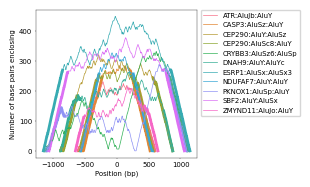

In [18]:
mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (65/scaling_factor) / mm_per_in
target_height_in = (60/scaling_factor) /mm_per_in

width_ratios = [1]
fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in), #(15,4)
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3})

validated_se_mfe_mountain_melt = create_mountain_melt(mountain_val_1kb)
validated_se_mfe_mountain_melt_cep290 = create_mountain_melt(mountain_cep290_1kb)
create_mountain_plot(validated_se_mfe_mountain_melt_cep290, ax=axs)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure4c_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure4c_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [19]:
# mm_per_in = 25.4
# scaling_factor = 1.23

# target_width_in = (65/scaling_factor) / mm_per_in
# target_height_in = (60/scaling_factor) /mm_per_in

# width_ratios = [1]
# fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in), #(15,4)
#                         gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3})

# validated_se_mfe_mountain_melt = create_mountain_melt(mountain_val_1kb)
# create_mountain_plot(validated_se_mfe_mountain_melt, ax=axs)
# plt.show()